# Zadanie: hiperparametry

Dla stworzonego wcześniej Pipeline’a wybierz najlepsze hiperparametry na podstawie podzbiorów walidacyjnych i siatki hiperparametrów (skorzystaj z GridSearch).

Starting grid search...
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Grid search completed!

=== Best Parameters ===
{'classifier__C': 10, 'classifier__l1_ratio': 0.1, 'classifier__penalty': 'l1', 'preprocessing__num__feature_select__k': 'all', 'preprocessing__num__poly__degree': 2}

=== Best CV F1 Score ===
0.738

=== Training Set Performance ===
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      7000
           1       0.77      0.71      0.74      3500

    accuracy                           0.83     10500
   macro avg       0.82      0.80      0.81     10500
weighted avg       0.83      0.83      0.83     10500

Training F1: 0.741
Training AUC: 0.907

=== Test Set Performance ===
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      3000
           1       0.76      0.70      0.73      1500

    accuracy                           0.83      4500
   macro avg       0.81      0.79      0.80      4500
weighted avg       0.82      0.83      0.83      45

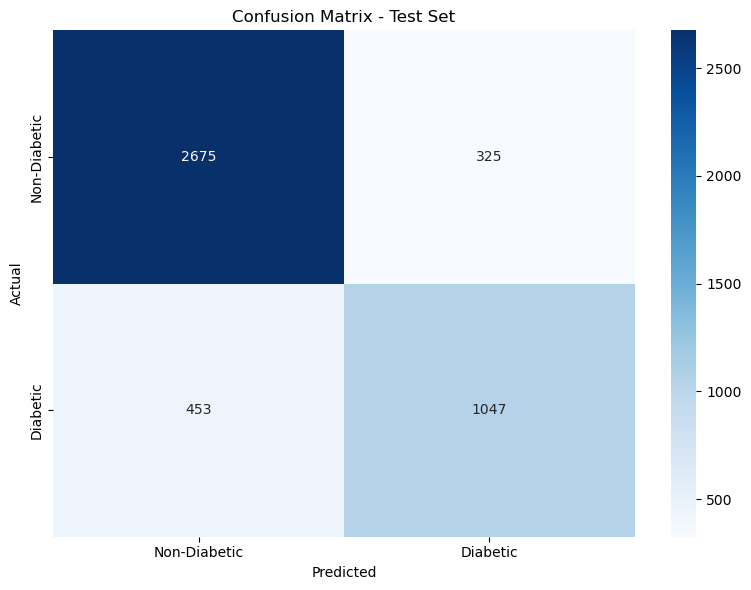

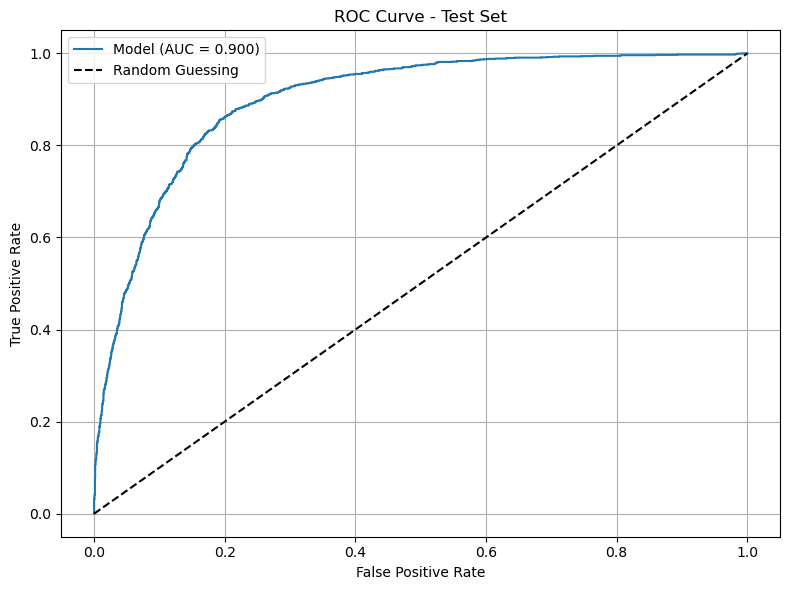


=== Feature Importance ===
                     Feature  Coefficient  Absolute
0                Pregnancies     1.712748  1.712748
7                        Age     1.061862  1.061862
8              Pregnancies^2    -0.850236  0.850236
4               SerumInsulin     0.748077  0.748077
5                        BMI     0.626815  0.626815
38                     BMI^2    -0.528462  0.528462
23  DiastolicBloodPressure^2    -0.380964  0.380964
6           DiabetesPedigree     0.328385  0.328385
1              PlasmaGlucose     0.320001  0.320001
3           TricepsThickness     0.315195  0.315195
43                     Age^2    -0.261035  0.261035
2     DiastolicBloodPressure     0.205091  0.205091
13           Pregnancies BMI     0.160846  0.160846
12  Pregnancies SerumInsulin     0.160163  0.160163
34            SerumInsulin^2    -0.142678  0.142678


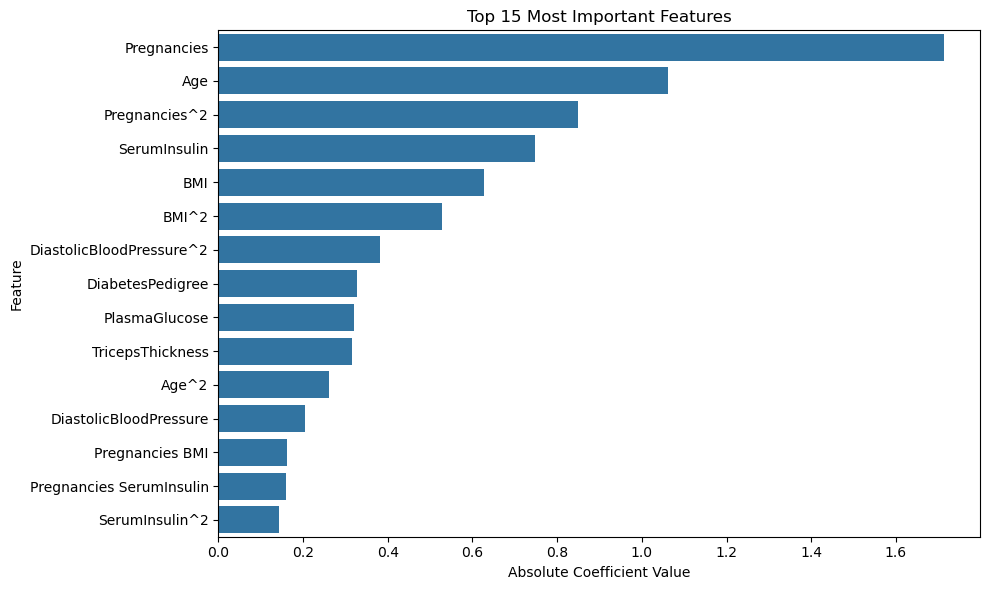


=== Comparison with Simple Model ===
Simple Model (2 features) Test F1: 0.5509118541033434
Full Pipeline Test F1: 0.729108635097493
Improvement: 32.3%

Best model saved as 'diabetes_best_model.pkl'


C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


In [8]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_curve, f1_score, roc_auc_score)

# Set random seed for reproducibility
np.random.seed(42)

# 1. Load and prepare data
diabetes = pd.read_csv('diabetes.csv')
features = ['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure', 
           'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age']
target = 'Diabetic'
X, y = diabetes[features], diabetes[target]

# 2. Split data into train and test sets (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# 3. Define preprocessing pipeline
num_features = features  # All features are numerical

num_preprocessing = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
    ('scaler', StandardScaler()),  # Standardize features
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Add interactions
    ('feature_select', SelectKBest(score_func=f_classif))  # Feature selection
])

# Create full preprocessing pipeline
preprocessing = ColumnTransformer([
    ('num', num_preprocessing, num_features)
])

# 4. Create full pipeline with model
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', LogisticRegression(solver='saga', max_iter=10000, random_state=42))
])

# 5. Define comprehensive parameter grid for GridSearch
param_grid = {
    'preprocessing__num__poly__degree': [1, 2],  # With and without polynomial features
    'preprocessing__num__feature_select__k': [5, 8, 'all'],  # Different feature counts
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Regularization strengths
    'classifier__l1_ratio': [0.1, 0.5, 0.9]  # For elasticnet only
}

# 6. Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='f1',  # Optimize for F1 score
    n_jobs=-1,  # Use all available cores
    verbose=1,  # Show progress
    refit=True,  # Refit best model on full training set
    return_train_score=True  # Return training scores for analysis
)

print("Starting grid search...")
grid_search.fit(X_train, y_train)
print("Grid search completed!")

# 7. Get the best model and evaluate
best_model = grid_search.best_estimator_

# Predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# 8. Print comprehensive results
print("\n=== Best Parameters ===")
print(grid_search.best_params_)

print("\n=== Best CV F1 Score ===")
print(f"{grid_search.best_score_:.3f}")

print("\n=== Training Set Performance ===")
print(classification_report(y_train, y_train_pred))
print(f"Training F1: {f1_score(y_train, y_train_pred):.3f}")
print(f"Training AUC: {roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1]):.3f}")

print("\n=== Test Set Performance ===")
print(classification_report(y_test, y_test_pred))
print(f"Test F1: {f1_score(y_test, y_test_pred):.3f}")
print(f"Test AUC: {roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]):.3f}")

# 9. Confusion matrix visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Diabetic', 'Diabetic'],
            yticklabels=['Non-Diabetic', 'Diabetic'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

# 10. ROC curve visualization
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300)
plt.show()

# 11. Feature importance analysis
try:
    # Get feature names after polynomial expansion
    poly_feature_names = best_model.named_steps['preprocessing'].named_transformers_['num'].named_steps['poly'].get_feature_names_out(features)
    
    # Get selected features
    selected_mask = best_model.named_steps['preprocessing'].named_transformers_['num'].named_steps['feature_select'].get_support()
    selected_features = poly_feature_names[selected_mask]
    
    # Get coefficients
    if hasattr(best_model.named_steps['classifier'], 'coef_'):
        coefficients = best_model.named_steps['classifier'].coef_[0]
        feature_importance = pd.DataFrame({
            'Feature': selected_features,
            'Coefficient': coefficients,
            'Absolute': np.abs(coefficients)
        }).sort_values('Absolute', ascending=False)
        
        print("\n=== Feature Importance ===")
        print(feature_importance.head(15))
        
        # Plot top features
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Absolute', y='Feature', data=feature_importance.head(15))
        plt.title('Top 15 Most Important Features')
        plt.xlabel('Absolute Coefficient Value')
        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300)
        plt.show()
except Exception as e:
    print(f"\nCould not extract feature importance: {e}")

# 12. Comparison with simple model (like in original approach)
print("\n=== Comparison with Simple Model ===")
simple_features = ['Pregnancies', 'Age']
X_train_simple = X_train[simple_features]
X_test_simple = X_test[simple_features]

simple_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        penalty=grid_search.best_params_['classifier__penalty'],
        C=grid_search.best_params_['classifier__C'],
        l1_ratio=grid_search.best_params_['classifier__l1_ratio'],
        solver='saga',
        max_iter=10000,
        random_state=42
    ))
])

simple_pipeline.fit(X_train_simple, y_train)
y_test_simple_pred = simple_pipeline.predict(X_test_simple)

print("Simple Model (2 features) Test F1:", f1_score(y_test, y_test_simple_pred))
print("Full Pipeline Test F1:", f1_score(y_test, y_test_pred))
improvement = (f1_score(y_test, y_test_pred) - f1_score(y_test, y_test_simple_pred)) / f1_score(y_test, y_test_simple_pred) * 100
print(f"Improvement: {improvement:.1f}%")

# 13. Save the best model
import joblib
joblib.dump(best_model, 'diabetes_best_model.pkl')
print("\nBest model saved as 'diabetes_best_model.pkl'")